In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/images/car.jpg
/kaggle/input/images/auto.jpg
/kaggle/input/images/lorry.jpg
/kaggle/input/images/bus.jpg
/kaggle/input/qrcode/10rs.jpg
/kaggle/input/qrcode/20rs.jpg
/kaggle/input/qrcode/30rs.jpg
/kaggle/input/features-vgg16/pca_features.npy
/kaggle/input/features-vgg16/X_vgg16_features.npy
/kaggle/input/features-vgg16/augmented_Y.npy


In [1]:
import numpy as np
X = np.load("/kaggle/input/features-vgg16/X_vgg16_features.npy")
y = np.load("/kaggle/input/features-vgg16/augmented_Y.npy")

print(X.shape)
print(y.shape)

(3027, 100352)
(3027,)


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
import numpy as np
np.save('final_train_X', X_train)
np.save('final_train_y', y_train)
np.save('final_test_X', X_test)
np.save('final_test_y', y_test)

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2421, 100352)
(606, 100352)
(2421,)
(606,)


In [4]:
import gc
gc.collect()

0

# STACKING WITH 2 HIDDEN LAYES MLP

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from joblib import Parallel, delayed
from sklearn.neural_network import MLPClassifier

# Define base classifiers
svm_clf = SVC(C=0.6772, kernel='linear', probability=True, verbose=True)
log_reg_clf = LogisticRegression(max_iter=1486, verbose=True)
xgb_clf = XGBClassifier(n_estimators=95, max_depth=5, learning_rate=0.27, use_label_encoder=False, tree_method='gpu_hist', verbose=True)

# Train base classifiers in parallel
def train_classifier(clf, X_train, y_train):
    clf.fit(X_train, y_train)
    return clf

classifiers = [svm_clf, log_reg_clf, xgb_clf]
classifiers = Parallel(n_jobs=-1)(delayed(train_classifier)(clf, X_train, y_train) for clf in classifiers)

# Make predictions on validation set using base classifiers
svm_preds_train = classifiers[0].predict_proba(X_train)
log_reg_preds_train = classifiers[1].predict_proba(X_train)
xgb_preds_train = classifiers[2].predict_proba(X_train)

# Scale probabilities from logistic regression
log_reg_weight = 4  # Giving more weight to logistic regression predictions
log_reg_preds_train_scaled = log_reg_weight * log_reg_preds_train

# Stack predictions horizontally
stacked_preds_train = np.column_stack((svm_preds_train, log_reg_preds_train_scaled, xgb_preds_train))

# Train meta classifier on stacked predictions
meta_clf = MLPClassifier(hidden_layer_sizes=(100, 50, 50), max_iter=500, learning_rate_init=0.01, verbose=True)
meta_clf.fit(stacked_preds_train, y_train)

# Make predictions on test set using base classifiers
svm_preds_test = classifiers[0].predict_proba(X_test)
log_reg_preds_test = classifiers[1].predict_proba(X_test)
xgb_preds_test = classifiers[2].predict_proba(X_test)

# Scale probabilities from logistic regression for test set
log_reg_preds_test_scaled = log_reg_weight * log_reg_preds_test

# Stack test predictions horizontally
stacked_preds_test = np.column_stack((svm_preds_test, log_reg_preds_test_scaled, xgb_preds_test))

# Make predictions using meta classifier
meta_preds = meta_clf.predict(stacked_preds_test)

# Evaluate meta classifier accuracy
meta_accuracy = accuracy_score(y_test, meta_preds)
print("Stacked Ensemble Classifier Accuracy with Neural Network as Meta Classifier:", meta_accuracy)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       401412     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35622D+03    |proj g|=  3.50415D+08


 This problem is unconstrained.


.............*...*.*
optimization finished, #iter = 10433
obj = -0.000000, rho = 213.069344
nSV = 140, nBSV = 0
Total nSV = 140
........*...*
optimization finished, #iter = 6775
obj = -0.000000, rho = 123.283041
nSV = 136, nBSV = 0
Total nSV = 136
........*..*
optimization finished, #iter = 6189
obj = -0.000000, rho = 196.937140
nSV = 132, nBSV = 0
Total nSV = 132

At iterate   50    f=  2.46050D+03    |proj g|=  1.50338D+07
.........*....*
optimization finished, #iter = 8334
obj = -0.000000, rho = 124.720650
nSV = 141, nBSV = 0
Total nSV = 141
........*...*
optimization finished, #iter = 6588
obj = -0.000000, rho = 154.217495
nSV = 139, nBSV = 0
Total nSV = 139


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:57:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:57:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)



At iterate  100    f=  2.18358D+03    |proj g|=  2.67629D+06
......*...*
optimization finished, #iter = 6959
obj = -0.000000, rho = -179.289596
nSV = 143, nBSV = 0

At iterate  150    f=  1.97615D+03    |proj g|=  1.09932D+06


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:58:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


........*...*
optimization finished, #iter = 11962
obj = -0.000000, rho = 77.489900
nSV = 155, nBSV = 0
Total nSV = 155

At iterate  200    f=  1.84147D+03    |proj g|=  2.57034D+06
.........*...*
optimization finished, #iter = 12793
obj = -0.000000, rho = 94.717959
nSV = 169, nBSV = 0
Total nSV = 169

At iterate  250    f=  1.67456D+03    |proj g|=  8.55792D+06
........*....*
optimization finished, #iter = 12958
obj = -0.000000, rho = 86.266908
nSV = 156, nBSV = 0
Total nSV = 156

At iterate  300    f=  1.64103D+03    |proj g|=  4.14752D+06
........*.....*
optimization finished, #iter = 13434
obj = -0.000000, rho = 87.618820
nSV = 172, nBSV = 0
Total nSV = 172

At iterate  350    f=  1.51005D+03    |proj g|=  1.61455D+06
.........*.*
optimization finished, #iter = 10394
obj = -0.000000, rho = 119.350509
nSV = 162, nBSV = 0
Total nSV = 162

At iterate  400    f=  1.38214D+03    |proj g|=  5.75466D+06
..............*....*
optimization finished, #iter = 18453
obj = -0.000000, rho = -95.0

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:16:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Iteration 1, loss = 0.34141867
Iteration 2, loss = 0.02375027
Iteration 3, loss = 0.00110286
Iteration 4, loss = 0.00010833
Iteration 5, loss = 0.00006152
Iteration 6, loss = 0.00005484
Iteration 7, loss = 0.00005396
Iteration 8, loss = 0.00005365
Iteration 9, loss = 0.00005345
Iteration 10, loss = 0.00005330
Iteration 11, loss = 0.00005317
Iteration 12, loss = 0.00005304
Iteration 13, loss = 0.00005291
Iteration 14, loss = 0.00005277
Iteration 15, loss = 0.00005265
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Stacked Ensemble Classifier Accuracy with Neural Network as Meta Classifier: 0.9686468646864687
[LibSVM][LibSVM]

In [20]:
# Scale probabilities from logistic regression
log_reg_weight = 4  # Giving more weight to logistic regression predictions
log_reg_preds_train_scaled = log_reg_weight * log_reg_preds_train

# Stack predictions horizontally
stacked_preds_train = np.column_stack((svm_preds_train, log_reg_preds_train_scaled, xgb_preds_train))

# Train meta classifier on stacked predictions
meta_clf = MLPClassifier(hidden_layer_sizes=(100, 50, 50), max_iter=500, learning_rate_init=0.01, verbose=True)
meta_clf.fit(stacked_preds_train, y_train)

# Make predictions on test set using base classifiers
svm_preds_test = classifiers[0].predict_proba(X_test)
log_reg_preds_test = classifiers[1].predict_proba(X_test)
xgb_preds_test = classifiers[2].predict_proba(X_test)

# Scale probabilities from logistic regression for test set
log_reg_preds_test_scaled = log_reg_weight * log_reg_preds_test

# Stack test predictions horizontally
stacked_preds_test = np.column_stack((svm_preds_test, log_reg_preds_test_scaled, xgb_preds_test))

# Make predictions using meta classifier
meta_preds = meta_clf.predict(stacked_preds_test)

# Evaluate meta classifier accuracy
meta_accuracy = accuracy_score(y_test, meta_preds)
print("Stacked Ensemble Classifier Accuracy with Neural Network as Meta Classifier:", meta_accuracy)

Iteration 1, loss = 0.39326166
Iteration 2, loss = 0.01391430
Iteration 3, loss = 0.00017860
Iteration 4, loss = 0.00012511
Iteration 5, loss = 0.00006952
Iteration 6, loss = 0.00005648
Iteration 7, loss = 0.00005381
Iteration 8, loss = 0.00005356
Iteration 9, loss = 0.00005341
Iteration 10, loss = 0.00005331
Iteration 11, loss = 0.00005322
Iteration 12, loss = 0.00005313
Iteration 13, loss = 0.00005304
Iteration 14, loss = 0.00005295
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Stacked Ensemble Classifier Accuracy with Neural Network as Meta Classifier: 0.9702970297029703


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        99
           1       0.98      0.94      0.96        69
           2       0.98      0.98      0.98       303
           3       0.94      0.97      0.96       135

    accuracy                           0.97       606
   macro avg       0.97      0.96      0.97       606
weighted avg       0.97      0.97      0.97       606



Text(70.72222222222221, 0.5, 'Actual')

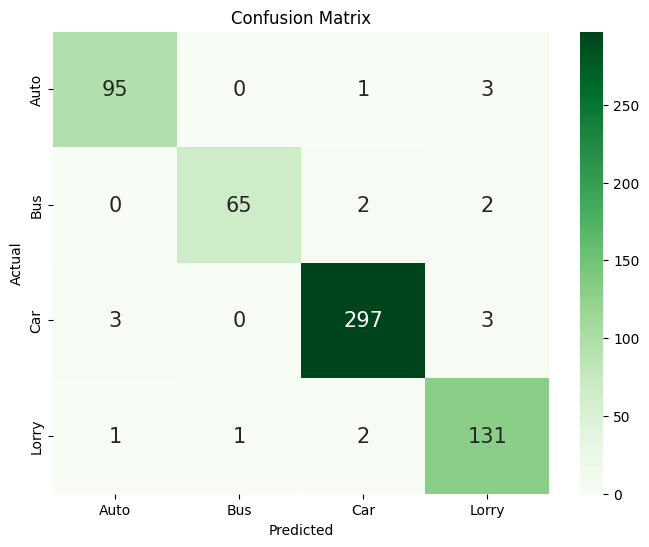

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Display classification report
print("Classification Report:")
print(classification_report(y_test, meta_preds))

# Display colored confusion matrix
conf_mat = confusion_matrix(y_test, meta_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=['Auto','Bus','Car','Lorry'], yticklabels=['Auto','Bus','Car','Lorry'], annot_kws={'size': 15})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [23]:
import joblib  

# Save the trained model to a file
model_filename = 'svm_clf_stacking.pkl'
joblib.dump(svm_clf, model_filename)
print(f"Model saved to {model_filename}")

model_filename = 'log_reg_clf_stacking.pkl'
joblib.dump(log_reg_clf, model_filename)
print(f"Model saved to {model_filename}")

model_filename = 'xgb_clf_stacking.pkl'
joblib.dump(xgb_clf, model_filename)
print(f"Model saved to {model_filename}")

model_filename = 'meta_clf_stacking.pkl'
joblib.dump(meta_clf, model_filename)
print(f"Model saved to {model_filename}")

Model saved to svm_clf_stacking.pkl
Model saved to log_reg_clf_stacking.pkl
Model saved to xgb_clf_stacking.pkl
Model saved to meta_clf_stacking.pkl
